In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_CIFAR10():
    train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
    test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

    np.set_printoptions(threshold=np.inf)

    X_train = train_dataset.data
    X_test = test_dataset.data

    y_train = np.array(train_dataset.targets)
    y_test = np.array(test_dataset.targets)

    X_train = X_train.reshape(50000, 32 * 32 * 3)
    X_test = X_test.reshape(10000, 32 * 32 * 3)
    
    '''
    X_train = X_train[:1000]
    X_test = X_test[:500]

    y_train = y_train[:1000]
    y_test = y_test[:500]
    '''
    
    X_train = X_train.astype("float")
    X_test = X_test.astype("float")

    return X_train, y_train, X_test, y_test

In [3]:
def softmax(f, X_train):
    '''
    -input: a vector of class scores
    -output: probability vector (non-negative, sums to 1)
    '''
    num_train = X_train.shape[0]
    # consider the numeric stability
    # find the largest score and subtract all scores by it in case exponential explosion
  
    #f_max = np.reshape(np.max(f, axis=1), (num_train, 1)) 
    f_max = np.max(f, axis=1, keepdims=True)    
    prob = np.exp(f - f_max) / np.sum(np.exp(f - f_max), axis=1, keepdims=True)
    return prob

In [4]:
def softmax_loss(W, b, X_train, y_train, reg):
    # initialization
    
    num_train = X_train.shape[0]
    num_feature = W.shape[0]
    num_class = W.shape[1]
    
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)
    loss = 0.0
    
    f_scores = X_train.dot(W) + b    # X * W, shape(num_train, num_class)    
    softmax_output = softmax(f_scores, X_train) # shape(num_train, num_class)
    
    real_classes = np.zeros(softmax_output.shape)
    real_classes[range(num_train), y_train] = 1.0   # shape(num_train, num_class)
    
    # calulate the loss
    loss += -np.sum(real_classes * np.log(softmax_output)) / num_train
    
    # calculate the gradient descent
    dW += -np.dot(X_train.T, real_classes - softmax_output) / num_train
    
    db += np.sum((real_classes - softmax_output),axis=0,keepdims=True) / num_train
    return loss, dW, db

In [5]:
def train(W, b, X_train, y_train, lr, reg, num_iters, batch_size):
    # initialization
    num_train = X_train.shape[0]
    num_feature = W.shape[0]
    
    for i in range(num_iters):
        
        X_batch = np.zeros((batch_size, num_feature))
        y_batch = np.zeros((batch_size))
        # randomly choose batch_size samples from X_train without repeatment
        idx_batch = np.random.choice(num_train,batch_size,replace=False)
        X_batch = X_train[idx_batch]
        y_batch = y_train[idx_batch]
        
        # get the loss and gradient
        loss, gradient, bias = softmax_loss(W, b, X_batch, y_batch, reg)
        
        #loss, gradient, bias = softmax_loss(W, b, X_train, y_train, reg)
        
        # grandient descent
        W -= gradient * lr
        b -= bias * lr
    return W,b

def predict_accuracy(W, b, X, y):
    num_train = X.shape[0]    
    scores = X.dot(W) + b
    
    y_prediction = np.zeros(num_train)
    y_prediction = np.argmax(scores, axis=1)
    
    accuracy = np.mean(y_prediction == y)
    return accuracy


In [15]:
def lr_schedule(X_train, y_train, lrs):   
    num_feature = X_train.shape[1]
    num_class = 10
    
    best_val = -1
    best_lr = 0.0   
    reg = 1e4
    accuracys = []  

    for lr in lrs:   
        W = 0.001 * np.random.randn(num_feature, num_class)
        b = 0.001 * np.random.randn(1, num_class)
        
        # train the data and get the updated W
        W,b = train(W, b, X_train, y_train, lr, reg, num_iters=3000, batch_size=200)
        train_accuracy = predict_accuracy(W, b, X_train, y_train)
        accuracys.append(train_accuracy)
        
        if(train_accuracy > best_val):
            best_val = train_accuracy
            best_lr = lr
            best_W = W
            best_b = b
            
        print("lr =", lr)
        print("the accuracy of training dataset is", train_accuracy)
        print('\n' + "-------------------------------------------------------" + '\n')
    
    plt.plot(lrs, accuracys)
    plt.ylabel('Accuracy of train dataset')
    plt.xlabel('learning rates')
    plt.title("accuracy on learning rate")
    plt.show()
    
    print("The best learning rate with highest training accuracy is", best_lr)
    print('\n' + "-------------------------------------------------------" + '\n')
    return best_lr, best_W, best_b

In [11]:
X_train, y_train, X_test, y_test = load_CIFAR10()

Files already downloaded and verified
Files already downloaded and verified


lr = 1e-07
the accuracy of training dataset is 0.27008

-------------------------------------------------------

lr = 2e-07
the accuracy of training dataset is 0.30114

-------------------------------------------------------

lr = 3e-07
the accuracy of training dataset is 0.32024

-------------------------------------------------------

lr = 4e-07
the accuracy of training dataset is 0.324

-------------------------------------------------------

lr = 5e-07
the accuracy of training dataset is 0.31952

-------------------------------------------------------

lr = 6e-07
the accuracy of training dataset is 0.34028

-------------------------------------------------------

lr = 7e-07
the accuracy of training dataset is 0.31044

-------------------------------------------------------

lr = 8e-07
the accuracy of training dataset is 0.30164

-------------------------------------------------------

lr = 9e-07
the accuracy of training dataset is 0.2587

-------------------------------------------

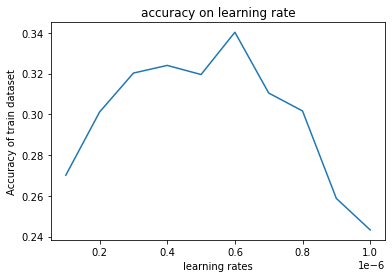

The best learning rate with highest training accuracy is 6e-07

-------------------------------------------------------

By using the best lr, the test accuracy is 0.3326


In [18]:
lrs = [1e-7,2e-7,3e-7,4e-7,5e-7,6e-7,7e-7,8e-7,9e-7,1e-6]
best_lr, W, b = lr_schedule(X_train, y_train, lrs)
test_accuracy = predict_accuracy(W, b, X_test, y_test)

print("By using the best lr, the test accuracy is", test_accuracy)